In [1]:
from types import SimpleNamespace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import windows
from scipy.fft import fftshift

from nodes.radar import Radar

In [2]:
args = SimpleNamespace(**{
  'cfg': 'configs/1443_mmwavestudio_config_continuous.lua',
  'host_ip': '192.168.33.30',
  'host_data_port': 4098,
})
radar = Radar(args)

c = 3e8                                                 # speed of light - m/s
SAMPLES_PER_CHIRP = radar.params['n_samples']           # adc number of samples per chirp
SAMPLE_RATE = radar.params['sample_rate']               # digout sample rate in Hz
FREQ_SLOPE = radar.params['chirp_slope']                # frequency slope in Hz (/s)

[INFO] Starting radar node with config: configs/1443_mmwavestudio_config_continuous.lua
[INFO] Connecting radar with host 192.168.33.30:4098
[INFO] Radar connected. Params:
platform                 : xWR14xx
adc_output_fmt           : 1
n_chirps                 : 8
rx                       : 1, 1, 1, 1
n_rx                     : 4
tx                       : 1, 1, 1
n_tx                     : 3
n_samples                : 512
frame_size               : 65536 bytes
frame_time               : 100 ms
chirp_time               : 162 µs
chirp_slope              : 60012000000000.0000 Hz/s
sample_rate              : 10000000.0000 samples/s
chirp_sampling_rate      : 80.0000 Hz
velocity_max             : 6.0125 m/s
velocity_res             : 0.7516 m/s
range_max                : 24.9950 m
range_res                : 0.0488 m
t_sweep                  : 0.0001 s


In [3]:
frame = radar.read()
frame.shape # shape (num_chirps, num_samples, num_rx)

Packet drop


(8, 512, 4)

c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


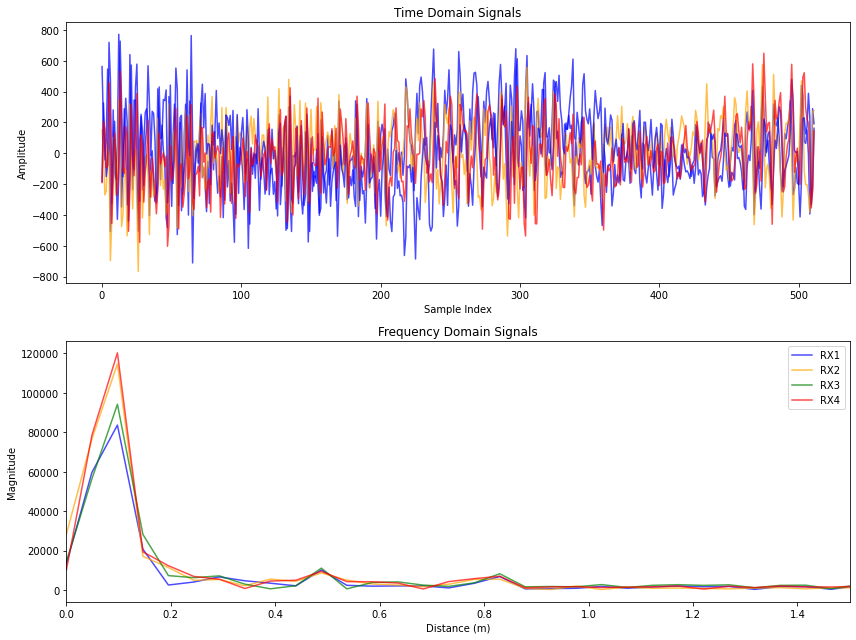

In [4]:
# signal = frame[0, :, :] # take the first chirp and first rx channel
signal = np.mean(frame, axis=0)
fft_result = fft(signal, axis=0)
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs * c / (2 * FREQ_SLOPE)

plt.figure(figsize=(12, 9))
# --- Time Domain Plot ---
plt.subplot(2, 1, 1)
plt.plot(signal[:, 0], color='blue', label='RX1', alpha=0.7)
plt.plot(signal[:, 1], color='orange', label='RX2', alpha=0.7)
plt.plot(signal[:, 2], color='blue', label='RX3', alpha=0.7)
plt.plot(signal[:, 3], color='red', label='RX4', alpha=0.7)
plt.title('Time Domain Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# --- Frequency Domain Plot ---
plt.subplot(2, 1, 2)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 0]), color='blue', label='RX1', alpha=0.7)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 1]), color='orange', label='RX2', alpha=0.7)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 2]), color='green', label='RX3', alpha=0.7)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 3]), color='red', label='RX4', alpha=0.7)
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0,1.5)
plt.tight_layout()

In [ ]:
radar.close()

## Object detection

In [22]:
# avg over chirps
avg_chirps = np.mean(frame, axis=0)     # shape: (num_samples, num_rx)
# choose rx0
signal = avg_chirps[:, 0]               # shape: (num_samples,)
signal.shape

(512,)

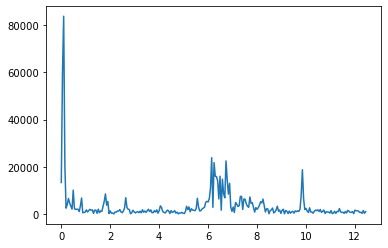

In [23]:
# ==== process data from radar with fft
fft_result = fft(signal)
fft_magnitude = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2])
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs[:SAMPLES_PER_CHIRP // 2] * c / (2 * FREQ_SLOPE)

plt.plot(fft_meters, fft_magnitude)

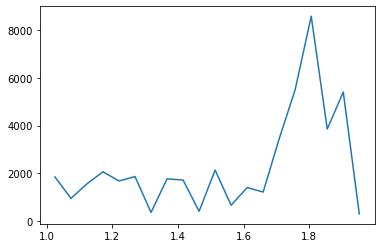

In [24]:
# ==== find peaks with distances
LOW = 1
HIGH = 2
range_mask = (fft_meters >= LOW) & (fft_meters <= HIGH)
fft_magnitude = fft_magnitude[range_mask]
fft_meters = fft_meters[range_mask]

plt.plot(fft_meters, fft_magnitude)

In [25]:
# ==== check if there is a strong peak at an inside box distance
THRESHOLD = 6000
any(fft_magnitude > THRESHOLD)

True